<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we will practice all the classification algorithms that we learned in this course.

First, we load a dataset using Pandas library then apply the relevant algorithms evaluate the accuracy to find the best one for this dataset.

First we load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes the following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off or in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan was made and took effect                                                |
| Due_date       | Since it’s one-time payment schedule, each loan has one single due date               |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-05-10 17:27:22--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-05-10 17:27:22 (140 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see the count of loan statuses in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to better understand the data:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

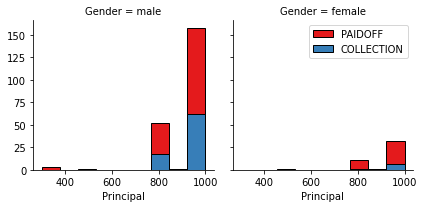

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

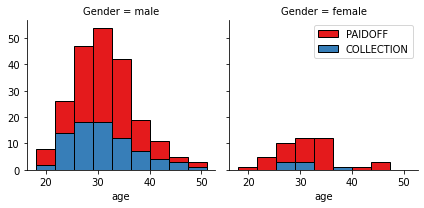

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


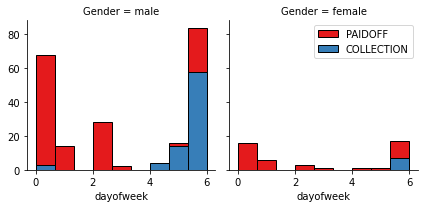

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['education'].replace(to_replace='Bechalor', value='Bachelors',inplace=True)
df['Gender'].head()


0    0
1    1
2    0
3    1
4    0
Name: Gender, dtype: int64

## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelors             PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bachelors
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bachelors,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bachelors,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?


In [18]:
# Replace PAIDOFF with 1 and COLLECTION with 0 for downstream models that can't handle strings
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y = df['loan_status']
y

0      1
1      1
2      1
3      1
4      1
      ..
341    0
342    0
343    0
344    0
345    0
Name: loan_status, Length: 346, dtype: int64

## Normalize Data


Data Standardization to give the data zero mean and unit variance (technically should be done after train test split )


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:**

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


## Import required modules

In [20]:
# Import required modules for preprocessing data
import numpy as np 
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import itertools
%matplotlib inline 
import scipy.optimize as opt

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix, classification_report, log_loss



## Define confusion matrix plotting function

In [21]:
# Make function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


## Test/train/split after Standard Scaling testing for best k and no other changes


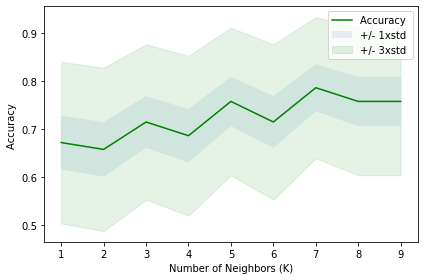

              precision    recall  f1-score   support

           0       0.50      0.40      0.44        15
           1       0.84      0.89      0.87        55

    accuracy                           0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70

Confusion matrix, without normalization
[[ 6  9]
 [ 6 49]]
F1 score is:  0.7766540244416351
Jaccard index is:  0.765625


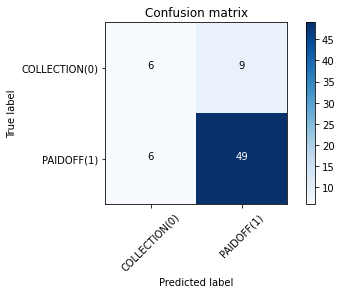

In [22]:
#Train/test/split after doing scaling/standardization (done above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#Generate and test accuracy of KNN model with K's from 1 to 10
Ks = 10
mean_acc = np.zeros((Ks-1))
stdev_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    Kneighbor = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train) #Train Model and Predict
    yhat=Kneighbor.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    stdev_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

#Graph of accuracy for different K's
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * stdev_acc,mean_acc + 1 * stdev_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * stdev_acc,mean_acc + 3 * stdev_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

#Generate model with best K
BestKNN_postsplit = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train) #Train Model and Predict
yhat_post=BestKNN_postsplit.predict(X_test)
yhat_post

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_post, labels=[0,1])
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat_post))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix')

#F1 score evaluation
print("F1 score is: ", f1_score(y_test, yhat_post, average='weighted'))

#Jaccard score evaluation
print("Jaccard index is: ", jaccard_score(y_test, yhat_post))

## Methods

In order to find the best model, I used a combination of nested cross-validation, StratifiedKFold and GridSearchCV to determine the best scaling/parameters.  I ran 10 trials of this process to gather reproducibility.
The process was as follows:
1. Nested cross-validation creates two different sets of train_test_splits of the data: a set for training the model and the other for testing generalizability of the parameters (validation set)
2. GridSearchCV was used to brute force test all combinations of parameters passed into param_grid and determine the best combination based on f1_score_weighted
3. For each trial, the winning parameters of GridSearchCV were then tested using the validation set to gather f1_score_weighted and jaccard statistics
4. The winning parameters/validation test scores for each trial were collected and summarized for final evaluation

## Grid Search with no scaling

In [117]:
# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {"n_neighbors": list(range(3,10)),
          "weights": ['uniform','distance'],
          "p": [1, 2, 3, 4]}
scoring = ['f1_weighted', 'jaccard']


# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_knn.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_knn, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_knn.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(["n_neighbors","p","weights"]).size())

# Group by params to calculate mean f1_weighted and jaccard stats then join column with counts of each group
results = param_scores.groupby(['n_neighbors','p','weights']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

,n_neighbors,p,weights,mean_f1_weighted,mean_jaccard,count
0,7.0,3.0,distance,0.687311,0.732790,1
1,7.0,4.0,distance,0.672500,0.686106,1
2,8.0,2.0,distance,0.676015,0.718338,1
3,9.0,1.0,distance,0.663798,0.668849,1
4,9.0,2.0,distance,0.659603,0.686980,3
5,9.0,2.0,uniform,0.667959,0.699394,3


## Grid Search with Standard Scaling


In [115]:
#Make a pipeline to run MinMaxScaler for KNN classification
KNN_pipe = Pipeline([('ss', StandardScaler()), ('knn', KNeighborsClassifier())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {"knn__n_neighbors": list(range(3,10)),
          "knn__weights": ['uniform','distance'],
          "knn__p": [1, 2, 3, 4]}
scoring = ['f1_weighted', 'jaccard']


# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_knn = GridSearchCV(KNN_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_knn.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_knn, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_knn.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(["knn__n_neighbors","knn__p","knn__weights"]).size())

# Group by params to calculate mean f1_weighted and jaccard stats then join column with counts of each group
results = param_scores.groupby(['knn__n_neighbors','knn__p','knn__weights']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

,knn__n_neighbors,knn__p,knn__weights,mean_f1_weighted,mean_jaccard,count
0,6.0,4.0,uniform,0.704547,0.683299,1
1,7.0,3.0,uniform,0.725034,0.723444,1
2,8.0,2.0,uniform,0.709245,0.700581,1
3,8.0,3.0,uniform,0.735324,0.709366,2
4,8.0,4.0,uniform,0.703871,0.690888,4
5,9.0,4.0,uniform,0.694614,0.683836,1


## Grid search for parameters with Robust Scaling

In [118]:
#Make a pipeline to run MinMaxScaler for KNN classification
KNN_pipe = Pipeline([('rs', RobustScaler()), ('knn', KNeighborsClassifier())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {"knn__n_neighbors": list(range(3,10)),
          "knn__weights": ['uniform','distance'],
          "knn__p": [1, 2, 3, 4]}
scoring = ['f1_weighted', 'jaccard']


# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_knn = GridSearchCV(KNN_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_knn.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_knn, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_knn.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(["knn__n_neighbors","knn__p","knn__weights"]).size())

# Group by params to calculate mean f1_weighted and jaccard stats then join column with counts of each group
results = param_scores.groupby(['knn__n_neighbors','knn__p','knn__weights']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

,knn__n_neighbors,knn__p,knn__weights,mean_f1_weighted,mean_jaccard,count
0,6.0,1.0,uniform,0.698929,0.694522,1
1,6.0,2.0,uniform,0.698090,0.666454,2
2,7.0,1.0,uniform,0.685978,0.657090,1
3,8.0,1.0,uniform,0.729381,0.705467,1
4,8.0,2.0,uniform,0.713632,0.687313,4
5,8.0,3.0,uniform,0.686614,0.678847,1


## Grid search with MinMax Scaling


In [119]:
#Make a pipeline to run MinMaxScaler for KNN classification
KNN_pipe = Pipeline([('mms', MinMaxScaler()), ('knn', KNeighborsClassifier())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {"knn__n_neighbors": list(range(3,10)),
          "knn__weights": ['uniform','distance'],
          "knn__p": [1, 2, 3, 4]}
scoring = ['f1_weighted', 'jaccard']


# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_knn = GridSearchCV(KNN_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_knn.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_knn, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_knn.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(["knn__n_neighbors","knn__p","knn__weights"]).size())

# Group by params to calculate mean f1_weighted and jaccard stats then join column with counts of each group
results = param_scores.groupby(['knn__n_neighbors','knn__p','knn__weights']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

,knn__n_neighbors,knn__p,knn__weights,mean_f1_weighted,mean_jaccard,count
0,7.0,1.0,uniform,0.692214,0.670730,2
1,8.0,1.0,uniform,0.711910,0.687254,5
2,8.0,4.0,uniform,0.711036,0.705784,2
3,9.0,1.0,uniform,0.716440,0.693912,1


## Results for KNN

The overall best scaling/parameters were chosen by the following criteria in order:
1. The most frequent winner of all trials
2. The highest mean_f1_weighted and mean_jaccard statistics

The results for each scaler were:

| Scaler   | n_neighbors | p   | weights | mean_f1_weighted | mean_jaccard | count |
| -------- | ----------- | --- | ------- | ---------------- | ------------ | ----- |
| Standard | 8.0         | 4.0 | uniform | 0.703871         | 0.690888     | 4     |
| Robust   | 8.0         | 2.0 | uniform | 0.713632         | 0.687313     | 4     |
| MinMax   | 8.0         | 1.0 | uniform | 0.711910         | 0.687254     | 5     |

### The best KNN model from these methods is:
-   MinMax Scaling after train_test_split
-   n_neighbors=8  
-   p=1  
-   knn_weights=uniform


### Confusion matrix for best KNN model using standardized split

              precision    recall  f1-score   support

           0       0.41      0.47      0.44        15
           1       0.85      0.82      0.83        55

    accuracy                           0.74        70
   macro avg       0.63      0.64      0.64        70
weighted avg       0.76      0.74      0.75        70

Confusion matrix, without normalization
[[ 7  8]
 [10 45]]


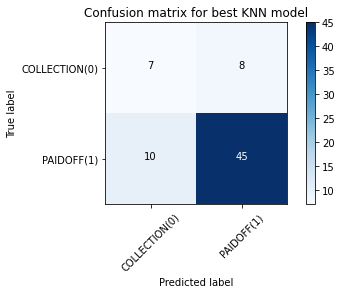

In [45]:
# Train/test/split before doing scaling/standardization (done above)
X_train, X_test, y_train, y_test = train_test_split(Feature, y, test_size=0.2, random_state=4)

# Scale data
scaler = MinMaxScaler()
norm_X_train = scaler.fit_transform(X_train)    # fit/transform x_train
norm_X_test = scaler.transform(X_test)     # transform the x_test based on x_train

# Generate best KNN model for standard split
StanSplit_KNN = KNeighborsClassifier(n_neighbors=8, p=1, weights='uniform').fit(norm_X_train, y_train) # Train Model and Predict
y_test_pred=StanSplit_KNN.predict(norm_X_test)

# Print classification report and compute confusion matrix
print (classification_report(y_test, y_test_pred))
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix for best KNN model')

# Scale full data
KNN_BestScaler = MinMaxScaler()
norm_Feature = KNN_BestScaler.fit_transform(Feature)    # fit/transform Feature

# Generate best KNN model from full data for future predictions
BestKNN = KNeighborsClassifier(n_neighbors=8, p=1, weights='uniform').fit(norm_Feature, y) # Generate/fit model for future predictions

# Decision Tree


## Methods

In order to find the best model, I used a combination of nested cross-validation and GridSearchCV to determine the best parameters.  I ran 10 trials of this process to gather reproducibility. Scaling was not considered because Decision Trees are invariant to scaling.
The process was as follows:
1. Nested cross-validation creates two different sets of train_test_splits of the data: a set for training the model and the other for testing generalizability of the parameters (validation set)
2. GridSearchCV was used to brute force test all combinations of parameters passed into param_grid and determine the best combination based on f1_score_weighted
3. For each trial, the winning parameters of GridSearchCV were then tested using the validation set to gather f1_score_weighted and jaccard statistics
4. The winning parameters/validation test scores for each trial were collected and summarized for final evaluation

### Decision tree using the default parameters from lessons

In [128]:
#Train/test/split, no scaling/standardization
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(Feature, y, test_size=0.2, random_state=4)

#Set up model
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree.fit(X_train_pre,y_train_pre)
predTree = drugTree.predict(X_test_pre)

#Evaluate accuracy

print("DecisionTree's F1 score is: ", f1_score(y_test_pre, predTree, average='weighted'))
print("DecisionTree's Jaccard index is: ", jaccard_score(y_test_pre, predTree))

DecisionTree's F1 score is:  0.6445993031358885
DecisionTree's Jaccard index is:  0.5714285714285714


### Grid search for best parameters with no scaling

In [43]:
%%time

# Number of random trials
NUM_TRIALS = 30

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {"criterion": ['entropy','gini'],
          "max_depth": list(range(3,9)),
          "splitter": ['best','random'],
          "min_samples_split": [2,3,4]}
scoring = ['f1_weighted', 'jaccard']

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_DecT = GridSearchCV(DecisionTreeClassifier(), cv=inner_cv, param_grid=p_grid, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_DecT.fit(Feature, y)

    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_DecT, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_DecT.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(["criterion","max_depth","splitter"]).size())

# Group by params to calculate mean f1_weighted and jaccard stats then join column with counts of each group
results = param_scores.groupby(['criterion','max_depth','splitter','min_samples_split']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 7.46 s, sys: 287 ms, total: 7.75 s
Wall time: 6min 6s


,criterion,max_depth,splitter,min_samples_split,mean_f1_weighted,mean_jaccard,count
0,entropy,4.0,random,3.0,0.661646,0.651345,1
1,entropy,5.0,best,2.0,0.671183,0.692400,1
2,entropy,5.0,random,3.0,0.687960,0.679062,3
3,entropy,5.0,random,4.0,0.701071,0.686989,3
4,entropy,6.0,best,4.0,0.664305,0.678432,1
5,entropy,6.0,random,3.0,0.662821,0.666211,1
6,entropy,7.0,random,2.0,0.670958,0.670619,3
7,entropy,7.0,random,3.0,0.670257,0.687827,3
8,entropy,8.0,random,2.0,0.653222,0.639169,5
9,entropy,8.0,random,3.0,0.683290,0.678563,5


## Results for Decision Tree

**Note: Decision trees tend to be fairly random but this was quick to run so I ran 30 trials and the most frequent winner on every batch of 30 trials is the same every time (total number of wins varies)**

The overall best parameters were chosen by the following criteria in order:
1. The most frequent winner of all trials
2. The highest mean_f1_weighted and mean_jaccard statistics

**The best Decision Tree model from these methods is:**
-   criterion=gini  
-   max_depth=8  
-   splitter=random
-   min_samples_split=4 because it had the best combination of F1-weighted and jaccard of the three versions that won 8x each 


### Confusion matrix for best Decision Tree model using standardized split

              precision    recall  f1-score   support

           0       0.27      0.20      0.23        15
           1       0.80      0.85      0.82        55

    accuracy                           0.71        70
   macro avg       0.53      0.53      0.53        70
weighted avg       0.68      0.71      0.70        70

Confusion matrix, without normalization
[[ 3 12]
 [ 8 47]]


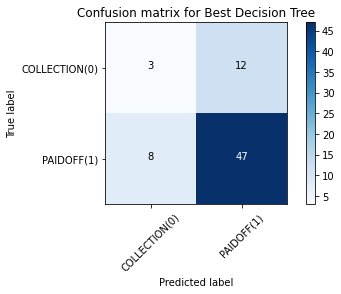

In [33]:
# Train/test/split before doing scaling/standardization (done above)
X_train, X_test, y_train, y_test = train_test_split(Feature, y, test_size=0.2, random_state=4)

# Test best KNN model on standardized split
StanSplit_DecT = DecisionTreeClassifier(criterion='gini', max_depth=8, splitter='random', min_samples_split=4).fit(X_train, y_train) # Train Model and Predict
y_test_pred=StanSplit_DecT.predict(X_test)

# Generate best Decision Tree model
BestDecT = DecisionTreeClassifier(criterion='gini', max_depth=8, splitter='random', min_samples_split=4).fit(X_train, y_train) # Train Model and Predict
y_test_pred=BestDecT.predict(X_test)

# Print classification report and compute confusion matrix
print (classification_report(y_test, y_test_pred))
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix for Best Decision Tree')

# Generate best Decision Tree model from full data for future predictions. No scaling for decision trees
BestDecT = DecisionTreeClassifier(criterion='gini', max_depth=8, splitter='random', min_samples_split=4).fit(Feature, y) # Generate/fit model for future predictions

# Support Vector Machine


## Methods

In order to find the best model, I used a combination of nested cross-validation and GridSearchCV to determine the best parameters.  I ran 10 trials of this process to gather reproducibility. SVMs require normalization and scaling and thus no scaling was not a consideration.
The process was as follows:
1. Nested cross-validation creates two different sets of train_test_splits of the data: a set for training the model and the other for testing generalizability of the parameters (validation set)
2. GridSearchCV was used to brute force test all combinations of parameters passed into param_grid and determine the best combination based on f1_score_weighted
3. For each trial, the winning parameters of GridSearchCV were then tested using the validation set to gather f1_score_weighted and jaccard statistics
4. The winning parameters/validation test scores for each trial were collected and summarized for final evaluation

### Use default settings from lessons to find model

The weighted f1 score is:  0.7275882012724117
The jaccard score is:  0.7272727272727273
              precision    recall  f1-score   support

           0       0.36      0.27      0.31        15
           1       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


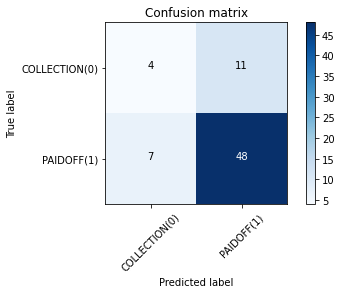

In [46]:
#Train test split using Features normalized beforehand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Generate model and set kernel then fit and generate predictions for accuracy testing
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

# Report f1 score
print("The weighted f1 score is: ", f1_score(y_test, y_test_pred, average='weighted'))

# Report jaccard score
print("The jaccard score is: ", jaccard_score(y_test, y_test_pred, pos_label=1))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)
print (classification_report(y_test, y_test_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix')

### Grid search for best parameters with Standard Scaling

In [23]:
%%time

#Make a pipeline to run StandardScaler for KNN classification
svm_pipe = Pipeline([('ss', StandardScaler()), ('svm', svm.SVC())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'svm__kernel': ['linear','rbf', 'sigmoid'],
          'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
          'svm__C': [0.1, 1, 10, 100],
          'svm__cache_size':[2000]}
scoring = ['f1_weighted', 'jaccard']

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_svm = GridSearchCV(svm_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_svm.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_svm, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_svm.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['svm__kernel','svm__C','svm__gamma']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['svm__kernel','svm__C','svm__gamma']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 3.28 s, sys: 60.5 ms, total: 3.34 s
Wall time: 2min 34s


,svm__kernel,svm__C,svm__gamma,mean_f1_weighted,mean_jaccard,count
0,rbf,10.0,1.0,0.698753,0.685504,9
1,rbf,100.0,1.0,0.684894,0.672402,1


In [25]:
%%time

#Make a pipeline to run StandardScaler for KNN classification
svm_pipe = Pipeline([('ss', StandardScaler()), ('svm', svm.SVC())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'svm__kernel': ['poly'],
          'svm__gamma': ['scale','auto',1, 0.1, 0.01],
          'svm__C': [0.1, 1, 10, 100],
          'svm__degree':[3,4,5],
          'svm__cache_size':[3000]}
scoring = ['f1_weighted', 'jaccard']

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_svm = GridSearchCV(svm_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_svm.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_svm, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_svm.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['svm__kernel','svm__C','svm__gamma','svm__degree']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['svm__kernel','svm__C','svm__gamma','svm__degree']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 51.3 s, sys: 52.8 ms, total: 51.3 s
Wall time: 12min 14s


,svm__kernel,svm__C,svm__gamma,svm__degree,mean_f1_weighted,mean_jaccard,count
0,poly,0.1,1,3.0,0.680160,0.678543,1
1,poly,0.1,1,4.0,0.664246,0.650694,2
2,poly,0.1,1,5.0,0.682486,0.665056,2
3,poly,1.0,1,3.0,0.669689,0.642626,1
4,poly,1.0,1,5.0,0.677421,0.647017,2
5,poly,100.0,1,5.0,0.677635,0.658761,1
6,poly,100.0,scale,5.0,0.647479,0.627902,1


### Grid search for best parameters with Robust Scaling

In [30]:
%%time

#Make a pipeline to run RobustScaler for KNN classification
svm_pipe = Pipeline([('rs', RobustScaler()), ('svm', svm.SVC())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'svm__kernel': ['rbf', 'sigmoid'],
          'svm__gamma': [1, 0.1, 0.01, 0.001,0.0001],
          'svm__C': [0.1, 1, 10, 100],
          'svm__cache_size':[4000]}
scoring = ['f1_weighted', 'jaccard']

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_svm = GridSearchCV(svm_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_svm.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_svm, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_svm.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['svm__kernel','svm__C','svm__gamma']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['svm__kernel','svm__C','svm__gamma']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 2.46 s, sys: 70.6 ms, total: 2.53 s
Wall time: 1min 54s


,svm__kernel,svm__C,svm__gamma,mean_f1_weighted,mean_jaccard,count
0,rbf,10.0,1.0,0.707479,0.691553,2
1,rbf,100.0,1.0,0.699211,0.688624,8


### Grid search for best parameters with MinMax Scaling

In [39]:
%%time

#Make a pipeline to run MinMaxScaler for KNN classification
svm_pipe = Pipeline([('mms', MinMaxScaler()), ('svm', svm.SVC())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'svm__kernel': ['rbf', 'sigmoid'],
          'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
          'svm__C': [0.1, 1, 10, 100],
          'svm__cache_size':[4000]}
scoring = ['f1_weighted', 'jaccard']

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_svm = GridSearchCV(svm_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_svm.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_svm, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_svm.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['svm__kernel','svm__C','svm__gamma']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['svm__kernel','svm__C','svm__gamma']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 2.46 s, sys: 67.3 ms, total: 2.53 s
Wall time: 1min 36s


,svm__kernel,svm__C,svm__gamma,mean_f1_weighted,mean_jaccard,count
0,rbf,10.0,1.0,0.673072,0.673312,4
1,rbf,100.0,0.1,0.667810,0.665214,3
2,sigmoid,100.0,0.1,0.681419,0.670146,3


In [33]:
%%time

#Make a pipeline to run MinMaxScaler for KNN classification
svm_pipe = Pipeline([('mmss', MinMaxScaler()), ('svm', svm.SVC())])

# Number of random trials
NUM_TRIALS = 10

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'svm__kernel': ['poly'],
          'svm__gamma': ['scale','auto',1, 0.1, 0.01],
          'svm__C': [0.1, 1, 10, 100],
          'svm__degree':[3,4,5],
          'svm__cache_size':[4000]}
scoring = ['f1_weighted', 'jaccard']

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_svm = GridSearchCV(svm_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_svm.fit(Feature, y)
    
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_svm, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_svm.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['svm__kernel','svm__C','svm__gamma','svm__degree']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['svm__kernel','svm__C','svm__gamma','svm__degree']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 2.97 s, sys: 81.6 ms, total: 3.05 s
Wall time: 1min 12s


,svm__kernel,svm__C,svm__gamma,svm__degree,mean_f1_weighted,mean_jaccard,count
0,poly,0.1,1,4.0,0.665944,0.675872,2
1,poly,1.0,1,5.0,0.696268,0.707804,1
2,poly,1.0,scale,4.0,0.697458,0.691542,1
3,poly,10.0,scale,3.0,0.695665,0.683027,1
4,poly,10.0,scale,5.0,0.689019,0.721557,1
5,poly,100.0,0.1,4.0,0.658903,0.655477,1
6,poly,100.0,0.1,5.0,0.672613,0.680414,1
7,poly,100.0,1,5.0,0.687523,0.713018,2


## Results for SVM

**Note: Polynomial fitting took too long to run for Robust Scaling and rarely returned a consensus winner. Polynomial was therefore excluded from consideration.**

The overall best parameters were chosen by the following criteria in order:
1. The most frequent winner of all trials
2. The highest mean_f1_weighted and mean_jaccard statistics

The results for each scaler were:

| Scaler   | kernel | C     | gamma | mean_f1_weighted | mean_jaccard | count |
| -------- | ------ | ----- | ----- | ---------------- | ------------ | ----- |
| Standard | rbf    | 10.0  | 1.0   | 0.698753         | 0.685504     | 9     |
| Robust   | rbf    | 100.0 | 1.0   | 0.699211         | 0.688624     | 8     |
| MinMax   | rbf    | 10.0  | 1.0   | 0.673072         | 0.673312     | 4     |

**The best SVM model from these methods is:**
-   Scaler= Standard
-   Kernel=rbf  
-   C=10  
-   gamma=1.0


### Confusion matrix for best SVM model using standardized split

              precision    recall  f1-score   support

           0       0.40      0.27      0.32        15
           1       0.82      0.89      0.85        55

    accuracy                           0.76        70
   macro avg       0.61      0.58      0.59        70
weighted avg       0.73      0.76      0.74        70

Confusion matrix, without normalization
[[ 4 11]
 [ 6 49]]


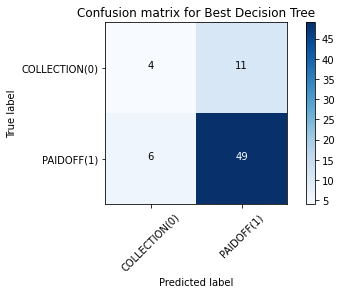

In [37]:
# Train/test/split before doing scaling/standardization (done above)
X_train, X_test, y_train, y_test = train_test_split(Feature, y, test_size=0.2, random_state=4)

# Scale data
scaler = StandardScaler()
norm_X_train = scaler.fit_transform(X_train)    # fit/transform x_train
norm_X_test = scaler.transform(X_test)     # transform the x_test based on x_train

# Test best KNN model on standardized split
StanSplit_SVM = svm.SVC(kernel='rbf', C=10, gamma=1.0).fit(X_train, y_train) # Train Model and Predict
y_test_pred=StanSplit_SVM.predict(X_test)

# Print classification report and compute confusion matrix
print (classification_report(y_test, y_test_pred))
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix for Best Decision Tree')

# Scale full data
SVM_BestScaler = StandardScaler()
norm_Feature = SVM_BestScaler.fit_transform(Feature)    # fit/transform Feature

# Generate best KNN model from full data for future predictions
BestSVM = svm.SVC(kernel='rbf', C=10, gamma=1.0).fit(norm_Feature, y) # Generate/fit model for future predictions

# Logistic Regression


## Methods

In order to find the best model, I used a combination of nested cross-validation and GridSearchCV to determine the best parameters.  I ran 10 trials of this process to gather reproducibility. SVMs require normalization and scaling and thus no scaling was not a consideration.
The process was as follows:
1. Nested cross-validation creates two different sets of train_test_splits of the data: a set for training the model and the other for testing generalizability of the parameters (validation set)
2. GridSearchCV was used to brute force test all combinations of parameters passed into param_grid and determine the best combination based on f1_score_weighted
3. For each trial, the winning parameters of GridSearchCV were then tested using the validation set to gather f1_score_weighted and jaccard statistics
4. The winning parameters/validation test scores for each trial were collected and summarized for final evaluation

### Grid search for best parameters with Standard Scaling

In [65]:
%%time

#Make a pipeline to run StandardScaler for KNN classification
lr_pipe = Pipeline([('ss', StandardScaler()), ('lr', LogisticRegression())])

# Number of random trials
NUM_TRIALS = 30

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'lr__solver': ['newton-cg', 'lbfgs','liblinear','sag','saga'],
          'lr__penalty': ['l1','l2'],
          'lr__C': [0.01, 0.1, 1, 2, 10, 100],
          'lr__max_iter': [1000],
          'lr__random_state':[3]}
scoring = ['f1_weighted', 'jaccard','neg_log_loss']

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_lr = GridSearchCV(lr_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_lr.fit(Feature, y)
    #yhat_prob = grid_lr.predict_prob(Feature)
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_lr, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_lr.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    temp['test_neg_log_loss'] = np.mean(nested_score['test_neg_log_loss'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['lr__solver','lr__penalty','lr__C']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['lr__solver','lr__penalty','lr__C']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean'), mean_neg_log_loss = ('test_neg_log_loss','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 10.5 s, sys: 360 ms, total: 10.9 s
Wall time: 9min 25s


,lr__solver,lr__penalty,lr__C,mean_f1_weighted,mean_jaccard,mean_neg_log_loss,count
0,liblinear,l1,1.00,0.655955,0.705115,-0.500626,2
1,liblinear,l1,2.00,0.662831,0.719129,-0.488439,4
2,liblinear,l1,10.00,0.665988,0.718919,-0.480728,3
3,liblinear,l1,100.00,0.663399,0.720229,-0.489894,5
4,liblinear,l2,0.01,0.642280,0.701549,-0.464378,2
5,liblinear,l2,1.00,0.670822,0.721987,-0.466367,2
6,liblinear,l2,2.00,0.672850,0.724795,-0.479991,5
7,newton-cg,l2,1.00,0.671957,0.712589,-0.467444,2
8,newton-cg,l2,2.00,0.646073,0.709648,-0.564781,1
9,saga,l1,0.01,0.637645,0.705864,-0.484535,1


### Grid search for best parameters with Robust Scaling

In [64]:
%%time

#Make a pipeline to run StandardScaler for KNN classification
lr_pipe = Pipeline([('rs', RobustScaler()), ('lr', LogisticRegression())])

# Number of random trials
NUM_TRIALS = 30

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'lr__solver': ['newton-cg', 'lbfgs','liblinear','sag','saga'],
          'lr__penalty': ['l1','l2'],
          'lr__C': [0.01, 0.1, 1, 2, 10, 100],
          'lr__max_iter': [1000],
          'lr__random_state':[3]}
scoring = ['f1_weighted', 'jaccard','neg_log_loss']
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_lr = GridSearchCV(lr_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_lr.fit(Feature, y)
    #yhat_prob = grid_lr.predict_prob(Feature)
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_lr, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_lr.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    temp['test_neg_log_loss'] = np.mean(nested_score['test_neg_log_loss'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['lr__solver','lr__penalty','lr__C']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['lr__solver','lr__penalty','lr__C']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean'), mean_neg_log_loss = ('test_neg_log_loss','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 11.3 s, sys: 428 ms, total: 11.8 s
Wall time: 12min 46s


,lr__solver,lr__penalty,lr__C,mean_f1_weighted,mean_jaccard,mean_neg_log_loss,count
0,lbfgs,l2,2.00,0.661439,0.699933,-0.522768,1
1,lbfgs,l2,100.00,0.675568,0.739818,-0.473205,1
2,liblinear,l1,1.00,0.655608,0.715449,-0.480819,3
3,liblinear,l1,2.00,0.667912,0.720969,-0.468820,3
4,liblinear,l1,10.00,0.669085,0.720133,-0.465564,7
5,liblinear,l1,100.00,0.671263,0.726188,-0.457349,3
6,liblinear,l2,100.00,0.661166,0.725613,-0.455784,1
7,newton-cg,l2,10.00,0.666812,0.734263,-0.492762,1
8,newton-cg,l2,100.00,0.675472,0.726044,-0.477025,3
9,sag,l2,1.00,0.653067,0.699234,-0.460711,2


### Grid search for best parameters with Robust Scaling

In [22]:
%%time

#Make a pipeline to run MinMaxScaler for KNN classification
lr_pipe = Pipeline([('mms', MinMaxScaler()), ('lr', LogisticRegression())])

# Number of random trials
NUM_TRIALS = 30

# Set up storage for best scores and params
nested_scores = pd.DataFrame()
best_params = pd.DataFrame()
results = pd.DataFrame()

# Set up dictionary of hyperparameters to test and scoring scheme
p_grid = {'lr__solver': ['newton-cg', 'lbfgs','liblinear','sag','saga'],
          'lr__penalty': ['l1','l2'],
          'lr__C': [0.01, 0.1, 1, 2, 10, 100],
          'lr__max_iter': [1000],
          'lr__random_state':[3]}
scoring = ['f1_weighted', 'jaccard','neg_log_loss']

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Loop for each nested cross-validation trial. Nested cross-validation does a gridsearch using inner_cv then does an unbiased cross-validation with outer-cv to check generalizability. Prevents "data leakage"
for i in range(NUM_TRIALS):

    # StratifiedKFold to keep same ratio of PAIDOFF/COLLECTION
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Gridsearch using full data set, n_split=5, shuffled to find best parameters. F1_weighted used as the metric for refitting. n_jobs=-1 to use all cores
    grid_lr = GridSearchCV(lr_pipe, param_grid=p_grid, cv=inner_cv, scoring=scoring, refit='f1_weighted', n_jobs=-1)
    grid_lr.fit(Feature, y)
    #yhat_prob = grid_lr.predict_prob(Feature)
    # Cross-validate with outer_cv to evaluate f1_weighted and jaccard using the model generated from inner_cv
    nested_score = cross_validate(grid_lr, X=Feature, y=y, cv=outer_cv, scoring=scoring, n_jobs=-1)
    
    # Store winning parameters and scores for each trial
    best_params = best_params.append(grid_lr.best_params_, ignore_index=True)
    temp = pd.DataFrame(nested_score['test_f1_weighted'], columns=['test_f1_weighted']).mean()      # Convert nested_score dictionary results to temp pandas DataFrame with the mean of the test_f1_weighted statistic
    temp['test_jaccard'] = np.mean(nested_score['test_jaccard'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    temp['test_neg_log_loss'] = np.mean(nested_score['test_neg_log_loss'].tolist())    # Add new column to temp DataFrame with the mean of the test_jaccard statistic
    nested_scores = nested_scores.append(temp, ignore_index=True)    # Append the statistics from temp DataFrame to nested_scores
    
# Combine parameters and cross_val scores for analysis.
param_scores = best_params.join(nested_scores)

# Group by the paramters to get count of each
param_count = pd.DataFrame(param_scores.groupby(['lr__solver','lr__penalty','lr__C']).size())

# Group by params, use .agg to calculate mean f1_weighted and jaccard stats, then join param_counts and cleanup
results = param_scores.groupby(['lr__solver','lr__penalty','lr__C']) \
    .agg(mean_f1_weighted = ('test_f1_weighted','mean'), mean_jaccard = ('test_jaccard','mean'), mean_neg_log_loss = ('test_neg_log_loss','mean')) \
    .join(param_count).rename(columns={0: 'count'}).reset_index()
results

CPU times: user 13.4 s, sys: 397 ms, total: 13.8 s
Wall time: 11min 9s


,lr__solver,lr__penalty,lr__C,mean_f1_weighted,mean_jaccard,mean_neg_log_loss,count
0,liblinear,l1,10.0,0.658338,0.722634,-0.470001,2
1,liblinear,l1,100.0,0.668674,0.721695,-0.461655,7
2,liblinear,l2,1.0,0.639353,0.708763,-0.470003,1
3,liblinear,l2,2.0,0.655739,0.707014,-0.483057,4
4,liblinear,l2,10.0,0.660208,0.714319,-0.492237,4
5,liblinear,l2,100.0,0.658584,0.721599,-0.462704,5
6,newton-cg,l2,1.0,0.655077,0.715242,-0.458842,1
7,newton-cg,l2,10.0,0.682752,0.717026,-0.473286,1
8,newton-cg,l2,100.0,0.674688,0.727823,-0.456777,1
9,saga,l1,10.0,0.675280,0.731303,-0.469987,3


## Results for Logistic Regression

These were fairly quick to run so I ran 30 iterations of each to determine which hyperparameters were best. I also increased the maximum iterations to ensure that the algorithms converged and added a random state integer<br>
so that the random state was the same between models but each maintained different splits for each iteration. For log loss evaluation, the only available scorer was neg_log_loss which is only the negative of the log_loss<br>
and therefore the closer to 0 neg_log_loss is, the better the performance.

The overall best parameters were chosen by the following criteria in order:
1. The most frequent winner of all trials for each scaling method
2. The highest mean_f1_weighted, mean_jaccard, and most negative mean neg_log_loss

The results for each scaler were:

| Scaler   | solver    | penalty | C     | mean_f1_weighted | mean_jaccard | mean neg_log_loss | count |
| -------- | --------- | ------- | ----- | ---------------- | ------------ | ----------------- | ----- |
| Standard | liblinear | l2      | 2.0   | 0.672850         | 0.724795     | -0.479991         | 5     |
| Robust   | liblinear | l1      | 10.0  | 0.669085         | 0.720133     | -0.465564         | 7     |
| MinMax   | liblinear | l1      | 100.0 | 0.668674         | 0.721695     | -0.461655         | 7     |

**The best Logistic Regression model from these methods is:**
-   Scaling= MinMax (tied with Robust for most wins but better Jaccard and neg_log_loss than Robust)
-   solver= liblinear
-   penalty= l1
-   C= 100


### Confusion matrix for best Logistic Regression model using standardized split

              precision    recall  f1-score   support

           0       0.22      0.13      0.17        15
           1       0.79      0.87      0.83        55

    accuracy                           0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.67      0.71      0.69        70

Confusion matrix, without normalization
[[ 2 13]
 [ 7 48]]


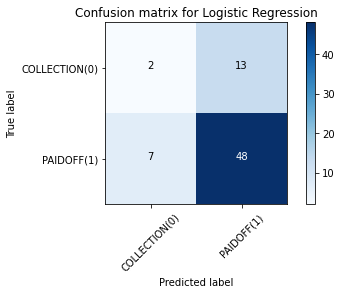

In [38]:
# Train/test/split before doing scaling/standardization (done above)
X_train, X_test, y_train, y_test = train_test_split(Feature, y, test_size=0.2, random_state=4)

# Scale data
scaler = MinMaxScaler()
norm_X_train = scaler.fit_transform(X_train)    # fit/transform x_train
norm_X_test = scaler.transform(X_test)     # transform the x_test based on x_train

# Generate best Decision Tree model
StanSplit_LogR = LogisticRegression(solver='liblinear', penalty='l1', C=100).fit(X_train, y_train) # Train Model and Predict
y_test_pred=StanSplit_LogR.predict(X_test)

# Print classification report and compute confusion matrix
print (classification_report(y_test, y_test_pred))
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix for Logistic Regression')

# Scale full data
LogR_BestScaler = MinMaxScaler()
norm_Feature = LogR_BestScaler.fit_transform(Feature)    # fit/transform Feature

# Generate best KNN model from full data for future predictions
BestLogR = LogisticRegression(solver='liblinear', penalty='l1', C=100).fit(norm_Feature, y) # Generate/fit model for future predictions

# Model Evaluation using Test set


In [39]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [40]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-05-10 20:34:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-05-10 20:34:17 (70.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [41]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Preprocess data to match above

In [42]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['education'].replace(to_replace='Bechalor', value='Bachelors',inplace=True)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
testset_features = test_df[['Principal','terms','age','Gender','weekend']]
testset_features = pd.concat([testset_features,pd.get_dummies(test_df['education'])], axis=1)
testset_features.drop(['Master or Above'], axis = 1,inplace=True)

testset_y = test_df['loan_status'].values


### Get performance for best KNN classifier

In [56]:
# Get predictions from best KNN
# Scale data and transform using BestKNN/Scaler made above
TestSet_KNNFeatures = KNN_BestScaler.fit(testset_features).transform(testset_features)     # transform the testset_features with scaler from original data
testset_y_pred=BestKNN.predict(TestSet_KNNFeatures)

#F1 score evaluation
print("F1 score is: ", f1_score(testset_y, testset_y_pred, average='weighted'))

#Jaccard score evaluation
print("Jaccard index is: ", jaccard_score(testset_y, testset_y_pred, pos_label=1))

F1 score is:  0.6063100137174212
Jaccard index is:  0.5882352941176471


### Get performance for best decision tree classifier

In [59]:
# Get predictions from best decision tree model generated before
testset_y_pred=BestDecT.predict(testset_features)

# F1 score evaluation
from sklearn.metrics import f1_score
print("F1 score is: ", f1_score(testset_y, testset_y_pred, average='weighted'))

# Jaccard score evaluation
from sklearn.metrics import jaccard_score
print("Jaccard index is: ", jaccard_score(testset_y, testset_y_pred, pos_label=1))

F1 score is:  0.7037037037037038
Jaccard index is:  0.6666666666666666


### Get performance for best SVM classifier

In [61]:
# Scale data and transform using BestSVM/Scaler made above
# Get predictions from best SVM
TestSet_SVMFeatures = SVM_BestScaler.fit(testset_features).transform(testset_features)     # transform the testset_features with scaler from original data
testset_y_pred=BestSVM.predict(TestSet_SVMFeatures)

# F1 score evaluation
print("F1 score is: ", f1_score(testset_y, testset_y_pred, average='weighted'))

# Jaccard score evaluation
print("Jaccard index is: ", jaccard_score(testset_y, testset_y_pred, pos_label=1))

F1 score is:  0.7001989201477693
Jaccard index is:  0.7


### Get performance for best logistic regression classifier

In [62]:
# Scale data and transform using BestLogR/Scaler made above
# Get predictions from best LogR
TestSet_LogRFeatures = LogR_BestScaler.fit(testset_features).transform(testset_features)     # transform the testset_features with scaler from original data
testset_y_pred=BestLogR.predict(TestSet_LogRFeatures)
testset_y_prob=BestLogR.predict_proba(TestSet_LogRFeatures)

# Generate best KNN model from full data for future predictions
BestLogR = LogisticRegression(solver='liblinear', penalty='l1', C=100).fit(norm_Feature, y) # Generate/fit model for future predictions

# F1 score evaluation
print("F1 score is: ", f1_score(testset_y, testset_y_pred, average='weighted'))

# Jaccard score evaluation
print("Jaccard index is: ", jaccard_score(testset_y, testset_y_pred, pos_label=1))

# Log loss score evaluation
print("Log loss is: ", log_loss(testset_y, testset_y_prob))

F1 score is:  0.6717642373556352
Jaccard index is:  0.7547169811320755
Log loss is:  0.4830761789489624


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.6063  | 0.5882   | NA      |
| Decision Tree      | 0.7037  | 0.6666   | NA      |
| SVM                | 0.7002  | 0.7000   | NA      |
| LogisticRegression | 0.6718  | 0.7547   | 0.4831  |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
